<a href="https://colab.research.google.com/github/karou1182001/NLPAssigments/blob/main/Assigment2/NLPAssigment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preguntas:
-El dataset que debemos usar es el mismo que el usa en los ejemplos del Github  Rta: Si
- Que cosas debemos comparar al comparar char level y word level y por que me dan los resultados asi: Histogram de todos las freq
- No se que se supone que debo cambiar en el modelo

# 1. Initial Setup


## Set Random Seeds:
Ensure reproducibility by setting seeds for all random number generators (e.g., Python’s random, NumPy, TensorFlow/PyTorch).

In [1]:
import random
import numpy as np
import torch
import tensorflow as tf

# Set random seed to 42
SEED = 1234

# Python random
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# TensorFlow
tf.random.set_seed(SEED)

print("Confirmation")


Confirmation


## Prepare the Environment:

Create a new or update an existing Jupyter Notebook.
Ensure that all necessary libraries (e.g., NumPy, pandas, TensorFlow/PyTorch, matplotlib, etc.) are installed.

In [2]:
!pip install numpy pandas matplotlib seaborn torch torchvision tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# 2. Preprocessing

## Load Dataset:
Load your dataset into the notebook.



In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

# -------------------------------
# Load and Prepare the IMDB Dataset
# -------------------------------
print("Loading IMDB dataset...")
# Load the IMDB reviews dataset with the 'as_supervised' flag so that we get (text, label) pairs.
(ds_train, ds_test), ds_info = tfds.load('imdb_reviews',
                                           split=['train', 'test'],
                                           as_supervised=True,
                                           with_info=True)

# Convert training dataset to lists.
train_texts = []
train_labels = []
for text, label in tfds.as_numpy(ds_train):
    # Decode byte strings to utf-8 strings.
    train_texts.append(text.decode('utf-8'))
    train_labels.append(label)
train_labels = np.array(train_labels)

# Create a validation set from the training data (20% for validation).
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42)

# Convert test dataset to lists.
test_texts = []
test_labels = []
for text, label in tfds.as_numpy(ds_test):
    test_texts.append(text.decode('utf-8'))
    test_labels.append(label)
test_labels = np.array(test_labels)

print(f"Train samples: {len(train_texts)}, Validation samples: {len(val_texts)}, Test samples: {len(test_texts)}")


Loading IMDB dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2HAFCF_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2HAFCF_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2HAFCF_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Train samples: 20000, Validation samples: 5000, Test samples: 25000


## Tokenization:





### Character-Level Tokenization:
Tokenize the text data at the character level.
Save and log the processed data.


In [4]:
# -------------------------------
# Character-Level Tokenizer and Preprocessing Functions
# -------------------------------
def char_level_tokenizer(texts, num_words=None):
    """
    Create and fit a character-level tokenizer.

    Args:
        texts (list of str): List of texts.
        num_words (int or None): Maximum number of tokens to keep.

    Returns:
        tokenizer: A fitted Tokenizer instance.
    """
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, char_level=True, lower=True)
    tokenizer.fit_on_texts(texts)
    return tokenizer

def texts_to_bow(tokenizer, texts):
    """
    Convert texts to a bag-of-characters representation.

    Args:
        tokenizer: A fitted character-level Tokenizer.
        texts (list of str): List of texts.

    Returns:
        Numpy array representing the binary bag-of-characters for each text.
    """
    # texts_to_matrix with mode 'binary' produces a fixed-length binary vector per text.
    matrix = tokenizer.texts_to_matrix(texts, mode='binary')
    return matrix

def one_hot_encode(labels, num_classes=2):
    """
    Convert numeric labels to one-hot encoded vectors.
    Convierte las palabras categorigas en un formato numerico
    """
    return np.eye(num_classes)[labels]

# -------------------------------
# Preprocessing: Tokenization and Vectorization
# -------------------------------

# Build the character-level tokenizer on the training texts.
tokenizer = char_level_tokenizer(train_texts)
print("Tokenizer vocabulary size:", len(tokenizer.word_index) + 1)

# Convert texts to bag-of-characters representation.
X_train = texts_to_bow(tokenizer, train_texts)
X_val   = texts_to_bow(tokenizer, val_texts)
X_test  = texts_to_bow(tokenizer, test_texts)

# Convert labels to one-hot encoding.
y_train = one_hot_encode(train_labels)
y_val   = one_hot_encode(val_labels)
y_test  = one_hot_encode(test_labels)

Tokenizer vocabulary size: 134


### Word-Level Tokenization:
Modify the tokenization process to tokenize the text by words.
Save and log the processed data.

In [8]:
# -------------------------------
# Word-Level Tokenizer and Preprocessing Functions
# -------------------------------
def word_tokenizer(texts, num_words=None):
    """
    Create and fit a word-level tokenizer.

    Args:
        texts (list of str): List of texts.
        num_words (int or None): Maximum number of tokens to keep.

    Returns:
        tokenizer: A fitted Tokenizer instance.
    """
    #We put char_level= False to be word level
    wordTokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, lower=True)
    wordTokenizer.fit_on_texts(texts)
    return wordTokenizer

def texts_to_bow(tokenizer, texts):
    """
    Convert texts to a bag-of-characters representation.

    Args:
        tokenizer: A fitted character-level Tokenizer.
        texts (list of str): List of texts.

    Returns:
        Numpy array representing the binary bag-of-characters for each text.
    """
    # texts_to_matrix with mode 'binary' produces a fixed-length binary vector per text.
    matrix = tokenizer.texts_to_matrix(texts, mode='binary')
    return matrix

def one_hot_encode(labels, num_classes=2):
    """
    Convert numeric labels to one-hot encoded vectors.
    Convierte las palabras categorigas en un formato numerico
    """
    return np.eye(num_classes)[labels]

# -------------------------------
# Preprocessing: Tokenization and Vectorization
# -------------------------------
# Build the character-level tokenizer on the training texts.
wordTokenizer = word_tokenizer(train_texts)
print("Word Tokenizer vocabulary size:", len(wordTokenizer.word_index) + 1)

# Convert texts to bag-of-characters representation.
X_train_word = texts_to_bow(wordTokenizer, train_texts)
X_val_word   = texts_to_bow(wordTokenizer, val_texts)
X_test_word  = texts_to_bow(wordTokenizer, test_texts)

# Convert labels to one-hot encoding.
y_train_word = one_hot_encode(train_labels)
y_val_word   = one_hot_encode(val_labels)
y_test_word  = one_hot_encode(test_labels)



Word Tokenizer vocabulary size: 80169


## Comparison:

Create a section in your notebook to compare the two tokenization approaches.
Visualize or tabulate differences in vocabulary size, sequence lengths, and other relevant metrics.

Character level vocabulary size: 134
Word level vocabulary size: 80169
char level sequence lengths: [2901, 1168, 2421, 1294, 985, 1514, 741, 546, 434, 1401, 655, 809, 739, 732, 1510, 650, 704, 656, 2258, 791, 2116, 906, 2833, 1493, 732, 781, 1223, 1471, 663, 1349, 1469, 839, 2091, 664, 3124, 476, 646, 997, 662, 1766, 678, 828, 1552, 630, 215, 1904, 386, 1102, 632, 1361, 791, 207, 1499, 1030, 1516, 2122, 1117, 2427, 541, 499, 1944, 984, 758, 439, 2484, 285, 403, 2156, 692, 261, 1508, 709, 1198, 1232, 912, 832, 1697, 1382, 1014, 1412, 1007, 5209, 1129, 1947, 303, 1211, 2456, 1553, 1792, 2809, 826, 775, 2015, 2671, 4081, 3182, 219, 1191, 782, 768, 802, 444, 1301, 446, 532, 4722, 4952, 653, 982, 654, 912, 645, 822, 1227, 2110, 997, 487, 1299, 5030, 1484, 1060, 651, 903, 1266, 723, 603, 650, 1077, 2549, 1199, 665, 4212, 1799, 1145, 316, 681, 1109, 1173, 1065, 491, 637, 1105, 839, 610, 938, 2543, 817, 3584, 685, 2735, 866, 865, 790, 1660, 1803, 2300, 1138, 1105, 3620, 508, 940, 425, 4427, 59

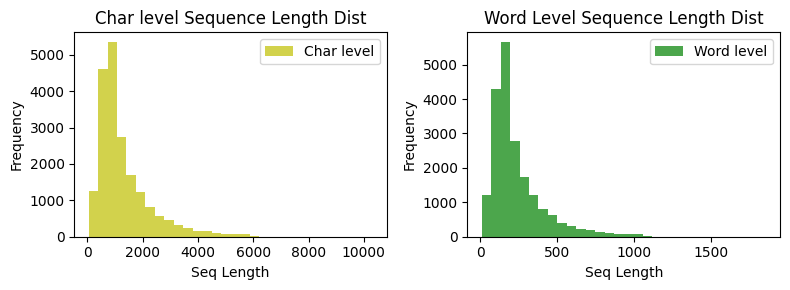

In [10]:
import matplotlib.pyplot as plt
# -------------------------------
# Comparison Between Tokenization Approaches
# -------------------------------
charSize = len(tokenizer.word_index) + 1
wordSize = len(wordTokenizer.word_index) + 1

#Convert to sew of index
charSeq = tokenizer.texts_to_sequences(train_texts)
wordSeq = wordTokenizer.texts_to_sequences(train_texts)

charseqLen =  [len(seq) for seq in charSeq]
wordseqLen = [len(seq) for seq in wordSeq]



print("Character level vocabulary size:", charSize)
print("Word level vocabulary size:", wordSize)
print("char level sequence lengths:", charseqLen)
print("word level sequence lengths:", wordseqLen)

# Visualization
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.hist(charseqLen, bins=30, alpha=0.7, color='y', label='Char level')
plt.xlabel('Seq Length')
plt.ylabel('Frequency')
plt.title('Char level Sequence Length Dist')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(wordseqLen, bins=30, alpha=0.7, color='g', label='Word level')
plt.xlabel('Seq Length')
plt.ylabel('Frequency')
plt.title('Word Level Sequence Length Dist')
plt.legend()

plt.tight_layout()
plt.show()


Analizing, the results makes sense since a the vocabulary of the word should be bigger than the vocabulary of char. And also, when can see in the histogram that the number of characters of each text is smaller than the number of words.

# 3. Model Architecture


## Define the Model:
Develop a model (or models) that can handle both tokenization types. Include the following adjustable hyper-parameters:


*   Learning rate
*   Number of hidden layers
*   Hidden sizes (neurons per layer)
*   Batch sizes
*   Optimizers (e.g., Adam, SGD, RMSProp)
*   Activation functions (e.g., ReLU, Tanh, LeakyReLU)

In [ ]:
# -------------------------------
# Model Setup
# -------------------------------
class MLP(object):
    def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
        """
        size_input: int, size of input layer
        size_hidden1: int, size of the 1st hidden layer
        size_hidden2: int, size of the 2nd hidden layer
        size_hidden3: int, size of the 3rd hidden layer (not used in compute_output here)
        size_output: int, size of output layer
        device: str or None, either 'cpu' or 'gpu' or None.
        """
        self.size_input = size_input
        self.size_hidden1 = size_hidden1
        self.size_hidden2 = size_hidden2
        self.size_hidden3 = size_hidden3  # (Currently not used in the forward pass)
        self.size_output = size_output
        self.device = device

        # Initialize weights and biases for first hidden layer
        self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1], stddev=0.1))
        self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1]))

        # Initialize weights and biases for second hidden layer
        self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2], stddev=0.1))
        self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))

        # Initialize weights and biases for output layer
        self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output], stddev=0.1))
        self.b3 = tf.Variable(tf.zeros([1, self.size_output]))

        # List of variables to update during backpropagation
        self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]


# The input size is determined by the dimension of the bag-of-characters vector.
size_input = X_train.shape[1]
# Set hidden layer sizes as desired.
size_hidden1 = 128
size_hidden2 = 64
size_hidden3 = 32  # Placeholder (not used in the forward pass)
size_output  = 2

# Instantiate the MLP model.
model = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None)

# Define the optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)